<a href="https://colab.research.google.com/github/dafrie/fin-disclosures-nlp/blob/master/notebooks/CRO_Multi_Class_classification_with_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarks

Ressources: 
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Config / Initialization

In [22]:
import pandas as pd
import numpy as np
from sklearn import metrics

############################## CONFIG ##############################
CATEGORY_LEVEL = 'cro' #@param ["cro", "cro_sub_type_combined"]
F1_AVERAGING_STRATEGY = 'macro' #@param ["micro",  "macro", "weighted"]
####################################################################

# To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
SEED_VALUE = 0

# Results file
RESULT_COLUMNS = ["model_id", "transformer_model", "category_level", "accuracy", "f1_score", "f1_score_avg_strat", "confusion_matrix"]
RESULTS_FILE = "/content/drive/My Drive/fin-disclosures-nlp/data/labels/Firm_AnnualReport_100_results_baseline.pkl"


In [23]:
# Load data
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_pickle("/content/drive/My Drive/fin-disclosures-nlp/data/labels/Firm_AnnualReport_Labels_100_positive.pkl")
df_neg = pd.read_pickle("/content/drive/My Drive/fin-disclosures-nlp/data/labels/Firm_AnnualReport_Labels_100_negative.pkl")
df_neg[CATEGORY_LEVEL] = "Not CRO"
df_neg = df_neg.groupby('neg_type').sample(1200, random_state=SEED_VALUE)

# Drop n/a's:
if CATEGORY_LEVEL == 'cro':
  df.query('cro == ["PR", "TR", "OP"]', inplace=True)
  no_of_categories = len(df.cro.unique())
else:
  df.query('cro_sub_type_combined.notnull() and cro_sub_type_combined != ""', inplace=True, engine='python')
  no_of_categories = len(df.cro_sub_type_combined.unique())

df = pd.concat([df, df_neg], ignore_index=True)

# Set texts and labels
docs = df.text
doc_labels = df[CATEGORY_LEVEL].astype('category').cat.codes.to_numpy(copy=True)

# TODO: Load test data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from sklearn.model_selection import train_test_split

# Split to train/test (temporary)
X_train, X_test, y_train, y_test = train_test_split(docs, doc_labels, test_size=0.1, random_state=SEED_VALUE)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the 2 datasets using tf-idf.
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(X_train)
vectors_test = vectorizer.transform(X_test)

print('{:>6,} train samples with {:<7,} features.'.format(vectors_train.shape[0], vectors_train.shape[1]))
print('{:>6,}  test samples with {:<7,} features.'.format(vectors_test.shape[0], vectors_test.shape[1]))

 3,213 train samples with 10,266  features.
   357  test samples with 10,266  features.


## Multinomial Naive Bayes classifier

Ressource: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=.01)

# Train the classifier on the training set.
clf.fit(vectors_train, y_train)

# Run prediction on the test set.
pred = clf.predict(vectors_test)

# Use the accuracy and F1 metric to score our classifier's performance on the test set.
accuracy = metrics.accuracy_score(y_test, pred)
score = metrics.f1_score(y_test, pred, average=F1_AVERAGING_STRATEGY)

# Report the scores
print('Accuracy: {:.3}'.format(accuracy))
print('F1 score: {:.3}'.format(score))

Accuracy: 0.754
F1 score: 0.413


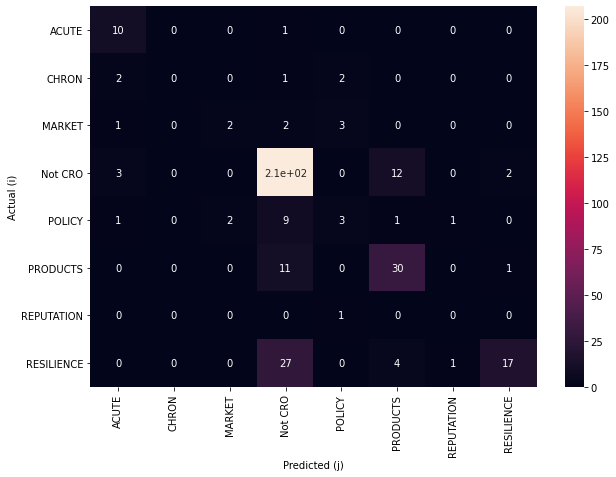

In [27]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion_m = metrics.confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(confusion_m, index = [c for c in df[CATEGORY_LEVEL].astype('category').cat.categories],
                  columns = [c for c in df[CATEGORY_LEVEL].astype('category').cat.categories])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True)
ax.set(xlabel="Predicted (j)", ylabel="Actual (i)")

bayes_result = pd.DataFrame([[f"bayes_{CATEGORY_LEVEL}", 'bayes', CATEGORY_LEVEL, accuracy, score, F1_AVERAGING_STRATEGY, df_cm]], columns=RESULT_COLUMNS)
bayes_result = bayes_result.set_index('model_id')

## Support Vector Machine (SVM)

In [28]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)

# Train the classifier on the training set.
clf.fit(vectors_train, y_train)

# Run prediction on the test set.
pred = clf.predict(vectors_test)

# Use the accuracy and F1 metric to score our classifier's performance on the test set.
accuracy = metrics.accuracy_score(y_test, pred)
score = metrics.f1_score(y_test, pred, average=F1_AVERAGING_STRATEGY)

# Report the scores
print('Accuracy: {:.3}'.format(accuracy))
print('F1 score: {:.3}'.format(score))

Accuracy: 0.742
F1 score: 0.337


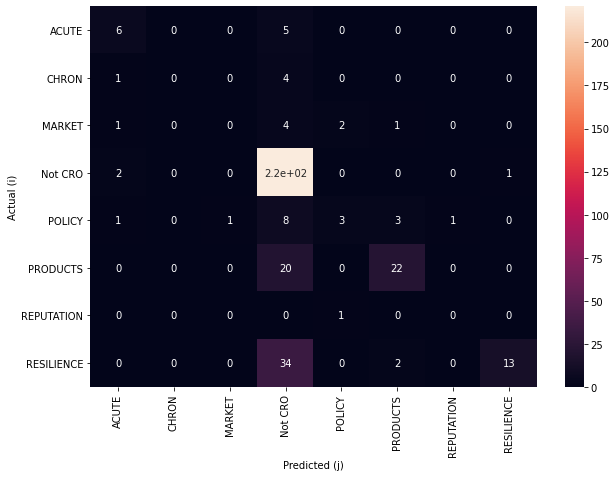

In [29]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion_m = metrics.confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(confusion_m, index = [c for c in df[CATEGORY_LEVEL].astype('category').cat.categories],
                  columns = [c for c in df[CATEGORY_LEVEL].astype('category').cat.categories])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True)
ax.set(xlabel="Predicted (j)", ylabel="Actual (i)")

svm_result = pd.DataFrame([[f"svm_{CATEGORY_LEVEL}", 'svm', CATEGORY_LEVEL, accuracy, score, F1_AVERAGING_STRATEGY, df_cm]], columns=RESULT_COLUMNS)
svm_result = svm_result.set_index('model_id')

# Store results

In [30]:
try:
  df_results = pd.read_pickle(RESULTS_FILE)
except FileNotFoundError:
  df_results = pd.DataFrame([], columns=RESULT_COLUMNS)
  df_results = df_results.set_index('model_id')
  df_results.to_pickle(RESULTS_FILE)

# Upsert values
df_results = pd.concat([df_results[~df_results.index.isin(bayes_result.index)], bayes_result])
df_results = pd.concat([df_results[~df_results.index.isin(svm_result.index)], svm_result])
df_results.to_pickle(RESULTS_FILE)
df_results

,transformer_model,category_level,accuracy,f1_score,f1_score_avg_strat,confusion_matrix
model_id,,,,,,
bayes_cro,bayes,cro,0.798883,0.764287,macro,Not CRO OP PR TR Not CRO 196 ...
svm_cro,svm,cro,0.818436,0.693441,macro,Not CRO OP PR TR Not CRO 215 ...
bayes_cro_sub_type_combined,bayes,cro_sub_type_combined,0.753501,0.413028,macro,ACUTE CHRON MARKET ... PRODUCT...
svm_cro_sub_type_combined,svm,cro_sub_type_combined,0.742297,0.337199,macro,ACUTE CHRON MARKET ... PRODUCT...


# Grid Search

TODO: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#parameter-tuning-using-grid-search

In [31]:
from sklearn.model_selection import GridSearchCV

parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3),
 }